# TrackChain analysis of precision

In [1]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import datetime
import os
from tqdm.notebook import tqdm
import math

## Defintion of constants

In [2]:
### ------------------------------ ###
### -------- DIRECTORIES --------- ###
### ------------------------------ ###

dir_src = os.path.abspath('')
dir_root = os.path.dirname(dir_src)
dir_data = os.path.join(dir_root, 'data')
dir_plots = os.path.join(dir_root, 'plots')

In [3]:
### ------------------------------ ###
### ----------- VALUES ----------- ###
### ------------------------------ ###

rho_gon = np.pi / 200 # Conversion factor from gon to radians
rho_deg = np.pi / 180 # Conversion factor from degree to radians

sigma_dist_default = 50 # [mm]
sigma_tilt = 0.072 # [deg]
sigma_tilt_rad = sigma_tilt * rho_deg

num_sensors_default = 100 # Number of sensors in track chain
# num_points = num_sensors + 1 # Number of measurement points
dist_tot = 120 # [m] nominal distance between any two sensors

num_reps = int(1e6) # Number of repetitions for Monte Carlo simulation

h0 = 0 # Height level of first point

dist_lateral = 4.8
width_track = 1.435



## Definition of functions

In [4]:
def monte_carlo(
    num_sensors:int,
    sigma_tilt:float,
    sigma_dist:float,
    nominal_dist:float=None) -> tuple[np.ndarray, np.ndarray]:
    '''
    Analysis of precision using a Monte Carlo simulation

    Parameters
    ----------
    num_sensors : Integer
        Number of sensors used
    sigma_tilt : Float
        Standard deviation for the tilt angles
    sigma_dist : Float
        Standard deviation for the distances
    nominal_dist : Float, optional
        Nominal distance between any two points

    Returns
    -------
    std_open : np.ndarray
        Array of standard deviations per point with one end fixed
    std_closed : np.ndarray
        Array of standard deviations per point with both ends fixed
    std_open_lat : np.ndarray
        Array of standard deviations per point on the second track with one end fixed
    std_closed_lat : np.ndarray
        Array of standard deviations per point on the second track with both ends fixed
    '''
    
    if nominal_dist is None:
        nominal_dist = dist_tot / num_sensors

    num_points = num_sensors + 1

    num_lateral = int((dist_tot // dist_lateral) + 1)

    # Create random observations for the distances and the angles
    r_dist = np.random.normal(nominal_dist * 1000, sigma_dist, (num_sensors, num_reps))
    r_ang = np.random.normal(0, sigma_tilt * rho_deg, (num_sensors, num_reps))

    r_dist_lat = np.random.normal(width_track * 1000, sigma_dist, (num_lateral, num_reps))
    r_ang_lat = np.random.normal(0, sigma_tilt * rho_deg, (num_lateral, num_reps))

    # Height differences per point
    dh = r_dist * np.sin(r_ang)
    dh_lat = r_dist_lat * np.sin(r_ang_lat)

    # Cumulative sum of height differences, last point unknown
    h_open = np.insert(np.cumsum(dh, axis=0), 0, np.zeros(num_reps), axis=0)
    h_open_lat = h_open[::math.ceil(num_points / num_lateral)] + dh_lat

    # Correct for last point being known
    h_closed = h_open - np.multiply(np.repeat(h_open[-1,:][np.newaxis, :], num_points, axis=0), np.arange(0, num_points)[:,np.newaxis] / (num_points - 1))
    h_closed_lat = h_closed[::math.ceil(num_points / num_lateral)] + dh_lat

    std_open = np.std(h_open, axis=1)
    std_closed = np.std(h_closed, axis=1)
    std_open_lat = np.std(h_open_lat, axis=1)
    std_closed_lat = np.std(h_closed_lat, axis=1)

    return std_open, std_closed, std_open_lat, std_closed_lat

In [5]:
def empirical_std_tilt(
                        timedelta_days:int = None,
                        start_date:str = None,
                        start_date_format:str = '%Y-%m-%d %H:%M:%S'
                    ) -> float:
    '''
    Function to determine the empirical standard deviation of the tilt sensor data across a chosen timeframe

    Parameters
    ----------
    timedelta_days : Integer, optional
        The number of days to be considered.
        If None entire timeseries is used.
    start_date : str, optional
        Datetime string following the format sepecified in date_time_format.
        Needs to be set if timedelta_days is not None
    start_date_format : str, optional
        Datetime format string.

    Returns
    -------
    sensor_std : Float
        Empirical standard deviation of the tilt sensor across the chosen timedelta
    '''

    ### Import data
    sensor_raw = pd.read_csv(
        os.path.join(dir_data, 'Sensors_raw.csv'),
        sep=';',
        header=0,
        parse_dates=[['Date', 'Time']],
        infer_datetime_format=True,
        usecols=['Point', 'Date', 'Time', 'tilt_x0']
    )

    # Set the Dataframes index
    sensor_raw.set_index(['Point', 'Date_Time'], inplace=True)

    ### Filter chosen timedelta

    if timedelta_days is not None: # If None is specified use everything
        # If no start_date is specified use first measurement
        if start_date is None:
            start_date = sensor_raw.index.get_level_values(level=1).min()
        else:
            start_date = datetime.datetime.strptime(start_date, start_date_format)

        # Create the specified timedelta
        included_timedelta = datetime.timedelta(days=timedelta_days)

        # Filter the dataframe by Boolean mapping
        sensor_raw = sensor_raw[
            sensor_raw.index.map(
                lambda id: (id[1] >= start_date and id[1] <= start_date + included_timedelta)
            )
        ]

    ### Demean the data

    #Calculate the mean per sensor
    mean = sensor_raw.groupby(level=0).mean()

    # Demean every sensors measurements
    sensor_raw_demeaned = sensor_raw.subtract(mean, level=0)

    #Calcaulate the standard deviation
    sensor_std = sensor_raw_demeaned['tilt_x0'].std()
    
    return sensor_std

## Execution of analysis

In [6]:
# Calculate empirical standard deviation
sensor_std = empirical_std_tilt(timedelta_days=3)

# Define cases to be tested
dist_std_list = [0, 50, 100, 200]
num_sensor_list = [25, 50, 100]

In [23]:
# Create containers
std_dict = {}
std_lat_dict = {}

with tqdm(total=len(num_sensor_list) * len(dist_std_list)) as progress_bar:
    for num_sensors in num_sensor_list:
        nominal_dist = dist_tot / num_sensors
        for sigma_dist in dist_std_list:
            # For every case use predefined sigma for tilt and empirical sigma
            stds_open = monte_carlo(num_sensors=num_sensors, sigma_tilt=sigma_tilt, sigma_dist=sigma_dist, nominal_dist=nominal_dist)
            stds_closed = monte_carlo(num_sensors=num_sensors, sigma_tilt=sensor_std, sigma_dist=sigma_dist)
            std_dict[(num_sensors, sigma_dist, 'default')] = list(stds_open[:2])
            std_dict[(num_sensors, sigma_dist, 'empirical')] = list(stds_closed[:2])

            std_lat_dict[(num_sensors, sigma_dist, 'default')] = list(stds_open[2:])
            std_lat_dict[(num_sensors, sigma_dist, 'empirical')] = list(stds_closed[2:])

            progress_bar.update(1)

std_df = pd.DataFrame.from_dict(std_dict, orient='index', columns=['open', 'closed'])
std_df.index = pd.MultiIndex.from_tuples(std_df.index, names=['num_sensors', 'sigma_dist', 'sigma_tilt'])
std_df

std_lat_df = pd.DataFrame.from_dict(std_lat_dict, orient='index', columns=['open', 'closed'])
std_lat_df.index = pd.MultiIndex.from_tuples(std_lat_df.index, names=['num_sensors', 'sigma_dist', 'sigma_tilt'])
std_lat_df

  0%|          | 0/12 [00:00<?, ?it/s]

open  \
num_sensors sigma_dist sigma_tilt                                                      
25          0          default     [1.8015737081534238, 6.299478509173829, 8.7125...   
                       empirical   [0.10099469519381353, 0.35234055818728455, 0.4...   
            50         default     [1.8038040283666175, 6.298113570587414, 8.7148...   
                       empirical   [0.10094006724773137, 0.35223202664554615, 0.4...   
            100        default     [1.8084630003047186, 6.300415895427653, 8.7250...   
                       empirical   [0.10124648675325114, 0.352642391615272, 0.488...   
            200        default     [1.8211770719783134, 6.312901277789229, 8.7355...   
                       empirical   [0.10176568046372006, 0.3529793654751528, 0.48...   
50          0          default     [1.8041788005043793, 4.628979684198117, 6.3031...   
                       empirical   [0.10094394580336885, 0.2591072520599562, 0.35...   
            50         default     [1.804498120331065, 4.631811950108087, 6.30196...   
                       empirical   [0.10097953270507547, 0.2589490730314876, 0.35...   
            100        default     [1.808621800835451, 4.632198616882504, 6.29788...   
                       empirical   [0.10103199725079913, 0.25924338820840914, 0.3...   
            200        default     [1.8196742395059315, 4.6461326363816005, 6.315...   
                       empirical   [0.10185818459378372, 0.2601688879724249, 0.35...   
100         0          default     [1.8048657338617011, 3.5135510013737297, 4.628...   
                       empirical   [0.10083971153313097, 0.1966885101000503, 0.25...   
            50         default     [1.8079919830922184, 3.5173321264312616, 4.636...   
                       empirical   [0.10097031059407066, 0.19690505150635879, 0.2...   
            100        default     [1.807905563456655, 3.5245946675156556, 4.6430...   
                       empirical   [0.1011452306093728, 0.19715195023241996, 0.25...   
            200        default     [1.8197027629792881, 3.5560952340384318, 4.687...   
                       empirical   [0.10173726996872708, 0.19936960487166058, 0.2...   

                                                                              closed  
num_sensors sigma_dist sigma_tilt                                                     
25          0          default     [1.8015737081534238, 6.18362082757657, 8.37694...  
                       empirical   [0.10099469519381353, 0.34582079793463083, 0.4...  
            50         default     [1.8038040283666175, 6.180757715194405, 8.3768...  
                       empirical   [0.10094006724773137, 0.3457157694175584, 0.46...  
            100        default     [1.8084630003047186, 6.182351043261497, 8.3815...  
                       empirical   [0.10124648675325114, 0.3460175604283951, 0.46...  
            200        default     [1.8211770719783134, 6.197039401350757, 8.3969...  
                       empirical   [0.10176568046372006, 0.34646147009925604, 0.4...  
50          0          default     [1.8041788005043793, 4.548753711054858, 6.0658...  
                       empirical   [0.10094394580336885, 0.25468522768691215, 0.3...  
            50         default     [1.804498120331065, 4.552190446820473, 6.06746...  
                       empirical   [0.10097953270507547, 0.2544914968099801, 0.33...  
            100        default     [1.808621800835451, 4.5540710266098285, 6.0660...  
                       empirical   [0.10103199725079913, 0.2548311358788484, 0.33...  
            200        default     [1.8196742395059315, 4.567487963003281, 6.0776...  
                       empirical   [0.10185818459378372, 0.2557289370498087, 0.34...  
100         0          default     [1.8048657338617011, 3.462172422176814, 4.4710...  
                       empirical   [0.10083971153313097, 0.19377699407800641, 0.2...  
            50         default     [1.8079919830922

## Create plots and analysze results

In [24]:
max_sensors = max(num_sensor_list)
min_sensors = min(num_sensor_list)

### Comparison of number of sensors

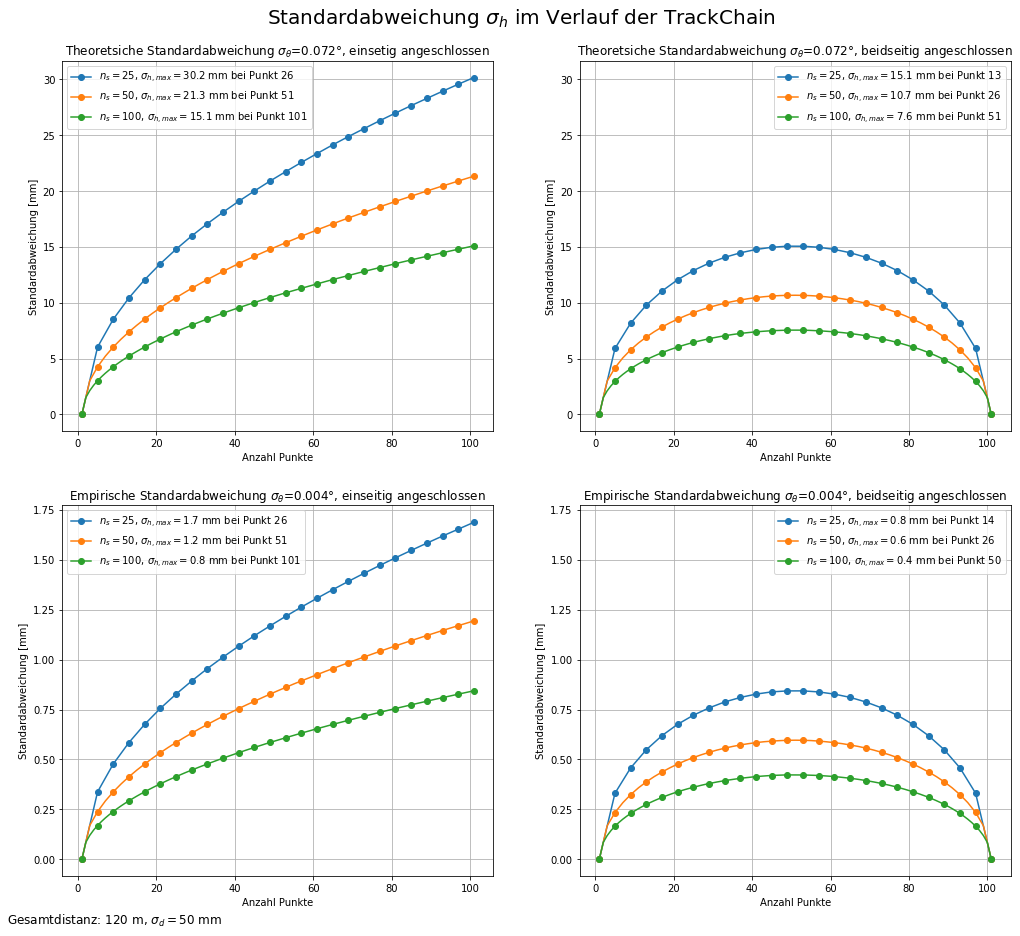

In [25]:
comparison_df = std_df.reorder_levels(['sigma_dist', 'sigma_tilt', 'num_sensors']).loc[sigma_dist_default]

fig, axs = plt.subplots(2, 2, figsize=(17,15))
fig.set_facecolor('white')
plt.suptitle(r'Standardabweichung $\sigma_h$ im Verlauf der TrackChain', size=20, y=0.93)
for num_sensors in num_sensor_list:
    num_points = num_sensors + 1
    
    x = np.arange(1, max_sensors + 2, max_sensors // num_sensors)
    y_00 = comparison_df.loc['default', num_sensors]['open']

    axs[0, 0].plot(
        x,
        y_00,
        label=rf'$n_s=${num_sensors}, $\sigma_{{h, max}}=${y_00.max():.1f} mm bei Punkt {y_00.argmax() + 1}',
        marker='o', 
        markevery=num_sensors//min_sensors
    )

    y_01 = comparison_df.loc['default', num_sensors]['closed']
    axs[0, 1].plot(
        x,
        y_01,
        label=rf'$n_s=${num_sensors}, $\sigma_{{h, max}}=${y_01.max():.1f} mm bei Punkt {y_01.argmax() + 1}',
        marker='o',
        markevery=num_sensors//min_sensors
    )

    y_10 = comparison_df.loc['empirical', num_sensors]['open']
    axs[1, 0].plot(
        x,
        y_10,
        label=rf'$n_s=${num_sensors}, $\sigma_{{h, max}}=${y_10.max():.1f} mm bei Punkt {y_10.argmax() + 1}',
        marker='o', 
        markevery=num_sensors//min_sensors
    )

    y_11 = comparison_df.loc['empirical', num_sensors]['closed']
    axs[1, 1].plot(
        x,
        y_11,
        label=rf'$n_s=${num_sensors}, $\sigma_{{h, max}}=${y_11.max():.1f} mm bei Punkt {y_11.argmax() + 1}',
        marker='o',
        markevery=num_sensors//min_sensors
    )

axs[0, 0].set_title(rf'Theoretsiche Standardabweichung $\sigma_\theta$={sigma_tilt:.3f}°, einsetig angeschlossen')
axs[0, 0].set_xlabel('Anzahl Punkte')
axs[0, 0].set_ylabel('Standardabweichung [mm]')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].set_title(rf'Theoretsiche Standardabweichung $\sigma_\theta$={sigma_tilt:.3f}°, beidseitig angeschlossen')
axs[0, 1].set_xlabel('Anzahl Punkte')
axs[0, 1].set_ylabel('Standardabweichung [mm]')
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].get_shared_y_axes().join(axs[0, 1], axs[0, 0])

axs[1, 0].set_title(rf'Empirische Standardabweichung $\sigma_\theta$={sensor_std:.3f}°, einseitig angeschlossen')
axs[1, 0].set_xlabel('Anzahl Punkte')
axs[1, 0].set_ylabel('Standardabweichung [mm]')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].set_title(rf'Empirische Standardabweichung $\sigma_\theta$={sensor_std:.3f}°, beidseitig angeschlossen')
axs[1, 1].set_xlabel('Anzahl Punkte')
axs[1, 1].set_ylabel('Standardabweichung [mm]')
axs[1, 1].legend()
axs[1, 1].grid()
axs[1, 1].get_shared_y_axes().join(axs[1, 1], axs[1, 0])

plt.figtext(
    0.08, 0.08,
    f'Gesamtdistanz: {dist_tot} m, $\sigma_d=${sigma_dist_default} mm',
    wrap=True,
    horizontalalignment='left',
    fontsize=12
)

plt.savefig(os.path.join(dir_plots, f'comp_no_sensors.png'), bbox_inches='tight')
plt.show()

### Comparison of single side fixed and both sides fixed

C:\Users\m.halbheer\AppData\Local\Temp\ipykernel_2236\2284458328.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  comparison_df = std_df.reorder_levels(['sigma_dist', 'num_sensors', 'sigma_tilt']).loc[sigma_dist_default, num_sensors_default]


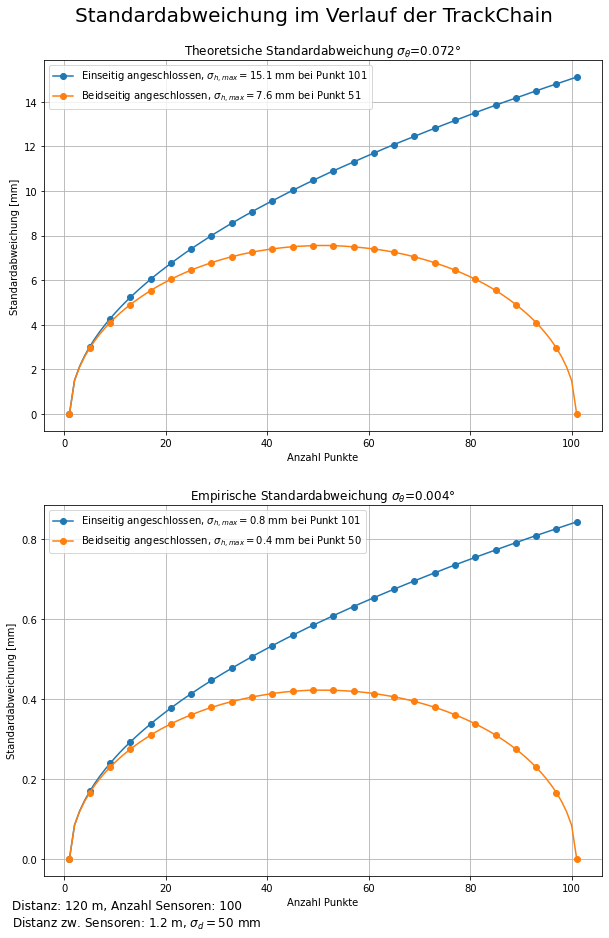

In [26]:
## Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10,15))
fig.set_facecolor('white')
plt.suptitle('Standardabweichung im Verlauf der TrackChain', size=20, y=0.93)

comparison_df = std_df.reorder_levels(['sigma_dist', 'num_sensors', 'sigma_tilt']).loc[sigma_dist_default, num_sensors_default]

x = np.arange(1, num_sensors_default + 2)
y_00 = comparison_df.loc['default']['open']
axs[0].set_title(rf'Theoretsiche Standardabweichung $\sigma_\theta$={sigma_tilt}°')
axs[0].plot(
    x,
    y_00,
    label=rf'Einseitig angeschlossen, $\sigma_{{h, max}}=${y_00.max():.1f} mm bei Punkt {y_00.argmax() + 1}',
    marker='o', 
    markevery=num_sensors_default//min_sensors
)
y_01 = comparison_df.loc['default']['closed']
axs[0].plot(
    x,
    y_01,
    label=rf'Beidseitig angeschlossen, $\sigma_{{h, max}}=${y_01.max():.1f} mm bei Punkt {y_01.argmax() + 1}',
    marker='o', 
    markevery=num_sensors_default//min_sensors
)
axs[0].set_xlabel('Anzahl Punkte')
axs[0].set_ylabel('Standardabweichung [mm]')
axs[0].legend()
axs[0].grid()

y_10 = comparison_df.loc['empirical']['open']
axs[1].set_title(rf'Empirische Standardabweichung $\sigma_\theta$={sensor_std:.3f}°')
axs[1].plot(
    x,
    y_10,
    label=rf'Einseitig angeschlossen, $\sigma_{{h, max}}=${y_10.max():.1f} mm bei Punkt {y_10.argmax() + 1}',
    marker='o', 
    markevery=num_sensors_default//min_sensors
)
y_11 = comparison_df.loc['empirical']['closed']
axs[1].plot(
    x,
    y_11,
    label=rf'Beidseitig angeschlossen, $\sigma_{{h, max}}=${y_11.max():.1f} mm bei Punkt {y_11.argmax() + 1}',
    marker='o', 
    markevery=num_sensors_default//min_sensors
)
axs[1].set_xlabel('Anzahl Punkte')
axs[1].set_ylabel('Standardabweichung [mm]')
axs[1].legend()
axs[1].grid()

plt.figtext(
    0.08, 0.08,
    f'Distanz: {dist_tot} m, Anzahl Sensoren: {num_sensors_default}\nDistanz zw. Sensoren: {dist_tot / num_sensors_default} m, $\sigma_d=${sigma_dist_default} mm',
    wrap=True,
    horizontalalignment='left',
    fontsize=12
)

plt.savefig(os.path.join(dir_plots, f'comp_open_closed.png'), bbox_inches='tight')
plt.show()

### Compare sigma for distance

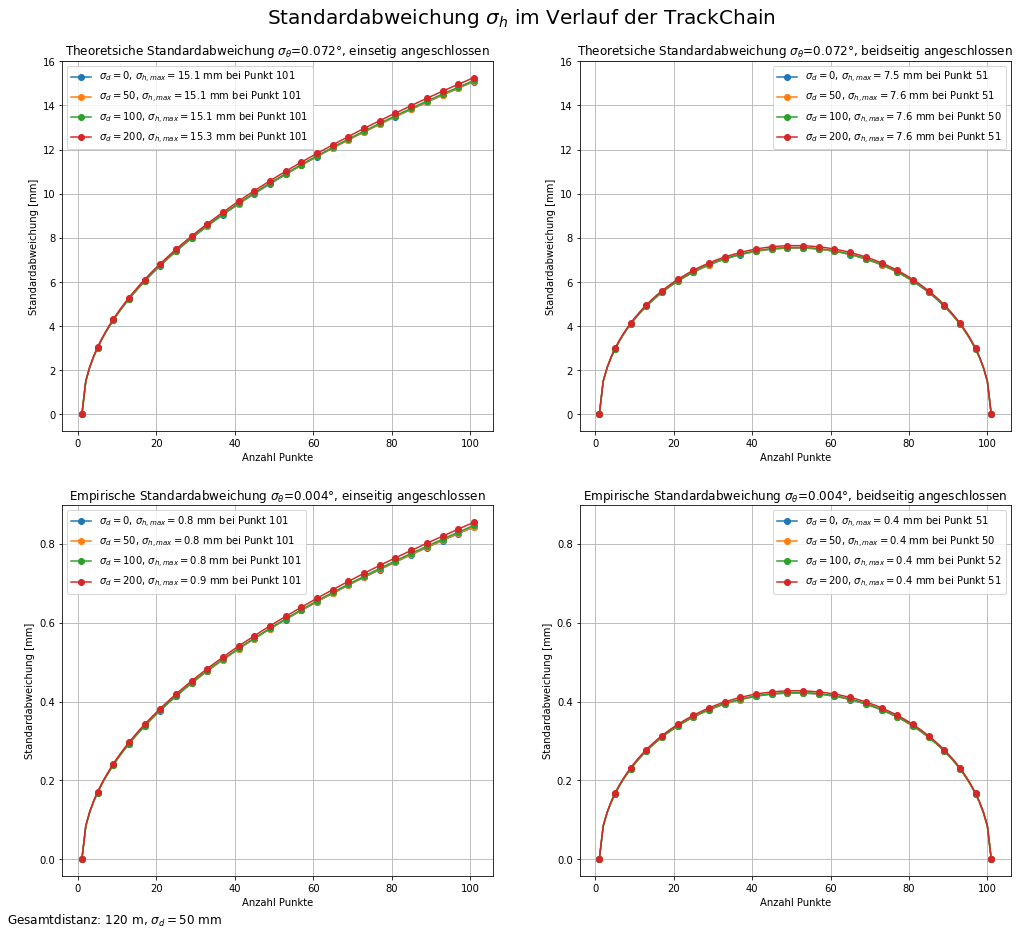

In [27]:
comparison_df = std_df.reorder_levels(['num_sensors', 'sigma_dist', 'sigma_tilt']).loc[num_sensors_default]

fig, axs = plt.subplots(2, 2, figsize=(17,15))
fig.set_facecolor('white')
plt.suptitle(r'Standardabweichung $\sigma_h$ im Verlauf der TrackChain', size=20, y=0.93)
for sigma_dist in dist_std_list:
    num_points = num_sensors + 1
    
    x = np.arange(1, num_points + 1)
    y_00 = comparison_df.loc[sigma_dist, 'default']['open']

    axs[0, 0].plot(
        x,
        y_00,
        label=rf'$\sigma_{{d}}=${sigma_dist}, $\sigma_{{h, max}}=${y_00.max():.1f} mm bei Punkt {y_00.argmax() + 1}',
        marker='o', 
        markevery=num_sensors_default//min_sensors
    )

    y_01 = comparison_df.loc[sigma_dist, 'default']['closed']
    axs[0, 1].plot(
        x,
        y_01,
        label=rf'$\sigma_{{d}}=${sigma_dist}, $\sigma_{{h, max}}=${y_01.max():.1f} mm bei Punkt {y_01.argmax() + 1}',
        marker='o', 
        markevery=num_sensors_default//min_sensors
    )

    y_10 = comparison_df.loc[sigma_dist, 'empirical']['open']
    axs[1, 0].plot(
        x,
        y_10,
        label=rf'$\sigma_{{d}}=${sigma_dist}, $\sigma_{{h, max}}=${y_10.max():.1f} mm bei Punkt {y_10.argmax() + 1}',
        marker='o', 
        markevery=num_sensors_default//min_sensors
    )

    y_11 = comparison_df.loc[sigma_dist, 'empirical']['closed']
    axs[1, 1].plot(
        x,
        y_11,
        label=rf'$\sigma_{{d}}=${sigma_dist}, $\sigma_{{h, max}}=${y_11.max():.1f} mm bei Punkt {y_11.argmax() + 1}',
        marker='o', 
        markevery=num_sensors_default//min_sensors
    )


axs[0, 0].set_title(rf'Theoretsiche Standardabweichung $\sigma_\theta$={sigma_tilt:.3f}°, einsetig angeschlossen')
axs[0, 0].set_xlabel('Anzahl Punkte')
axs[0, 0].set_ylabel('Standardabweichung [mm]')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].set_title(rf'Theoretsiche Standardabweichung $\sigma_\theta$={sigma_tilt:.3f}°, beidseitig angeschlossen')
axs[0, 1].set_xlabel('Anzahl Punkte')
axs[0, 1].set_ylabel('Standardabweichung [mm]')
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].get_shared_y_axes().join(axs[0, 1], axs[0, 0])

axs[1, 0].set_title(rf'Empirische Standardabweichung $\sigma_\theta$={sensor_std:.3f}°, einseitig angeschlossen')
axs[1, 0].set_xlabel('Anzahl Punkte')
axs[1, 0].set_ylabel('Standardabweichung [mm]')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].set_title(rf'Empirische Standardabweichung $\sigma_\theta$={sensor_std:.3f}°, beidseitig angeschlossen')
axs[1, 1].set_xlabel('Anzahl Punkte')
axs[1, 1].set_ylabel('Standardabweichung [mm]')
axs[1, 1].legend()
axs[1, 1].grid()
axs[1, 1].get_shared_y_axes().join(axs[1, 1], axs[1, 0])

plt.figtext(
    0.08, 0.08,
    f'Gesamtdistanz: {dist_tot} m, $\sigma_d=${sigma_dist_default} mm',
    wrap=True,
    horizontalalignment='left',
    fontsize=12
)

plt.savefig(os.path.join(dir_plots, f'comp_sigma_dist.png'), bbox_inches='tight')
plt.show()

## Measurement with lateral sensor every 4.8 m

### Compare the lateral sigma for an open and closed chain

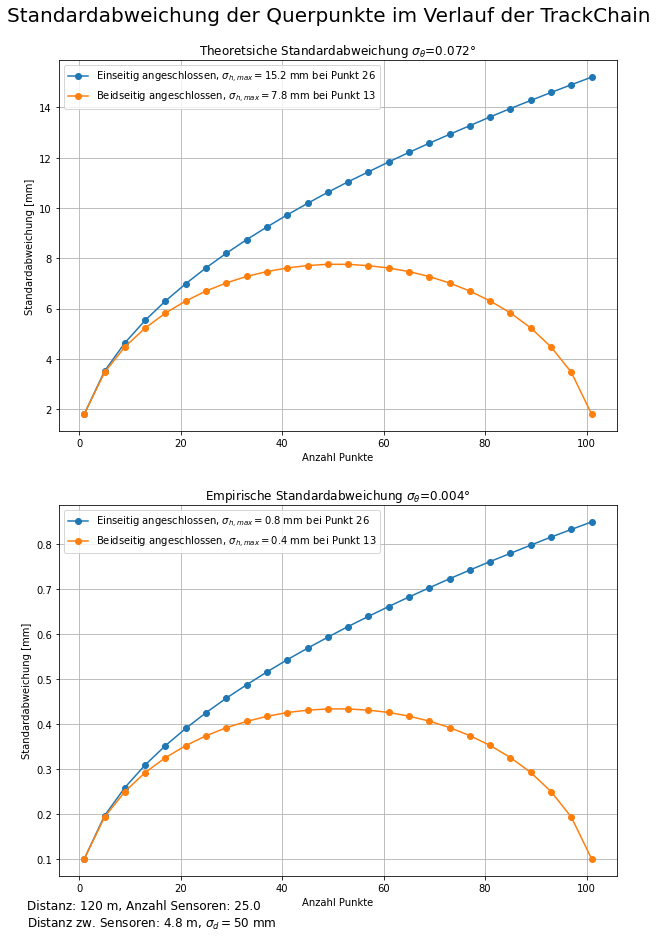

In [28]:
## Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10,15))
fig.set_facecolor('white')
plt.suptitle('Standardabweichung der Querpunkte im Verlauf der TrackChain', size=20, y=0.93)

comparison_df = std_lat_df.loc[num_sensors_default, sigma_dist_default]

x = np.arange(1, num_sensors_default + 2, dist_lateral // nominal_dist)
y_00 = comparison_df.loc['default']['open']
axs[0].set_title(rf'Theoretsiche Standardabweichung $\sigma_\theta$={sigma_tilt}°')
axs[0].plot(
    x,
    y_00,
    label=rf'Einseitig angeschlossen, $\sigma_{{h, max}}=${y_00.max():.1f} mm bei Punkt {y_00.argmax() + 1}',
    marker='o', 
    markevery=1
)
y_01 = comparison_df.loc['default']['closed']
axs[0].plot(
    x,
    y_01,
    label=rf'Beidseitig angeschlossen, $\sigma_{{h, max}}=${y_01.max():.1f} mm bei Punkt {y_01.argmax() + 1}',
    marker='o', 
    markevery=1
)
axs[0].set_xlabel('Anzahl Punkte')
axs[0].set_ylabel('Standardabweichung [mm]')
axs[0].legend()
axs[0].grid()

y_10 = comparison_df.loc['empirical']['open']
axs[1].set_title(rf'Empirische Standardabweichung $\sigma_\theta$={sensor_std:.3f}°')
axs[1].plot(
    x,
    y_10,
    label=rf'Einseitig angeschlossen, $\sigma_{{h, max}}=${y_10.max():.1f} mm bei Punkt {y_10.argmax() + 1}',
    marker='o', 
    markevery=1
)
y_11 = comparison_df.loc['empirical']['closed']
axs[1].plot(
    x,
    y_11,
    label=rf'Beidseitig angeschlossen, $\sigma_{{h, max}}=${y_11.max():.1f} mm bei Punkt {y_11.argmax() + 1}',
    marker='o', 
    markevery=1
)
axs[1].set_xlabel('Anzahl Punkte')
axs[1].set_ylabel('Standardabweichung [mm]')
axs[1].legend()
axs[1].grid()

plt.figtext(
    0.08, 0.08,
    f'Distanz: {dist_tot} m, Anzahl Sensoren: {dist_tot // dist_lateral}\nDistanz zw. Sensoren: {dist_lateral} m, $\sigma_d=${sigma_dist_default} mm',
    wrap=True,
    horizontalalignment='left',
    fontsize=12
)

plt.savefig(os.path.join(dir_plots, f'comp_open_closed_lateral.png'), bbox_inches='tight')
plt.show()

### Compare the standard deviation depending on the sensors of points on the first track

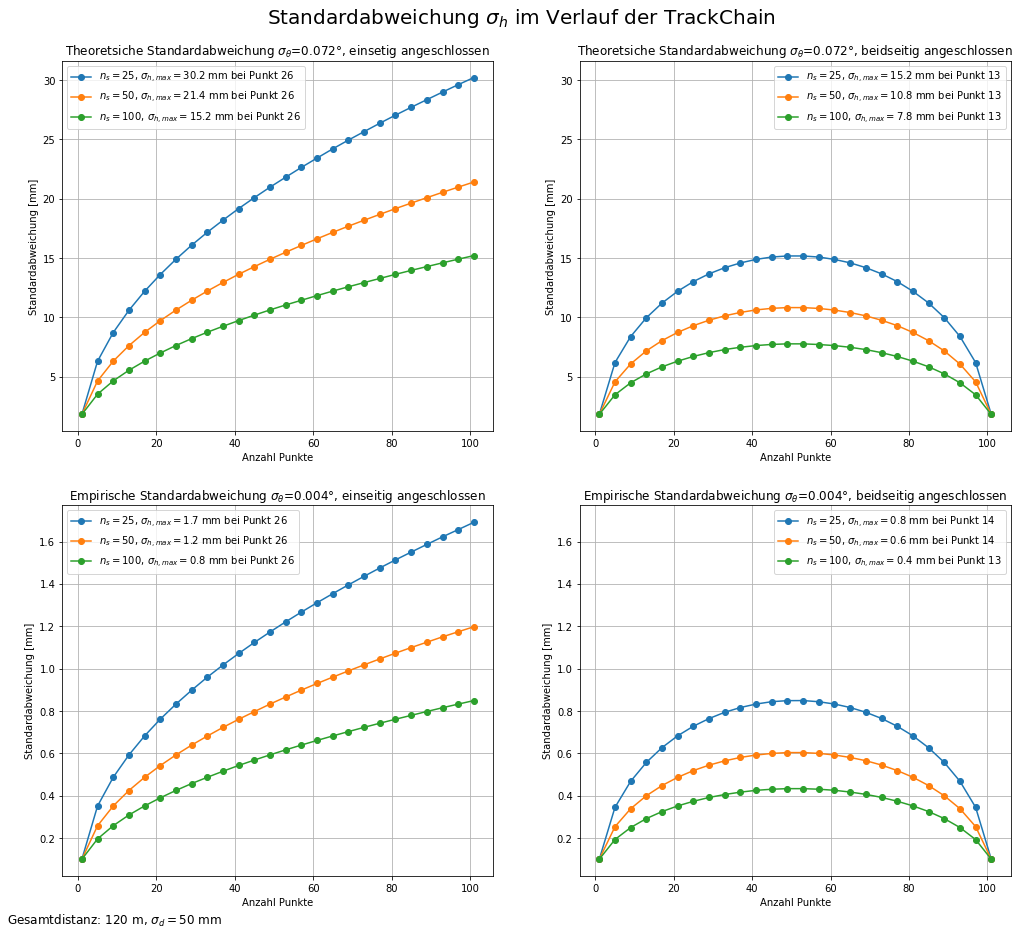

In [29]:
comparison_df = std_lat_df.reorder_levels(['sigma_dist', 'sigma_tilt', 'num_sensors']).loc[sigma_dist_default]

fig, axs = plt.subplots(2, 2, figsize=(17,15))
fig.set_facecolor('white')
plt.suptitle(r'Standardabweichung $\sigma_h$ im Verlauf der TrackChain', size=20, y=0.93)
for num_sensors in num_sensor_list:
    num_points = num_sensors + 1
    
    x = np.arange(1, max_sensors + 2, dist_lateral // nominal_dist)
    y_00 = comparison_df.loc['default', num_sensors]['open']

    axs[0, 0].plot(
        x,
        y_00,
        label=rf'$n_s=${num_sensors}, $\sigma_{{h, max}}=${y_00.max():.1f} mm bei Punkt {y_00.argmax() + 1}',
        marker='o', 
        markevery=1
    )

    y_01 = comparison_df.loc['default', num_sensors]['closed']
    axs[0, 1].plot(
        x,
        y_01,
        label=rf'$n_s=${num_sensors}, $\sigma_{{h, max}}=${y_01.max():.1f} mm bei Punkt {y_01.argmax() + 1}',
        marker='o',
        markevery=1
    )

    y_10 = comparison_df.loc['empirical', num_sensors]['open']
    axs[1, 0].plot(
        x,
        y_10,
        label=rf'$n_s=${num_sensors}, $\sigma_{{h, max}}=${y_10.max():.1f} mm bei Punkt {y_10.argmax() + 1}',
        marker='o', 
        markevery=1
    )

    y_11 = comparison_df.loc['empirical', num_sensors]['closed']
    axs[1, 1].plot(
        x,
        y_11,
        label=rf'$n_s=${num_sensors}, $\sigma_{{h, max}}=${y_11.max():.1f} mm bei Punkt {y_11.argmax() + 1}',
        marker='o',
        markevery=1
    )

axs[0, 0].set_title(rf'Theoretsiche Standardabweichung $\sigma_\theta$={sigma_tilt:.3f}°, einsetig angeschlossen')
axs[0, 0].set_xlabel('Anzahl Punkte')
axs[0, 0].set_ylabel('Standardabweichung [mm]')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].set_title(rf'Theoretsiche Standardabweichung $\sigma_\theta$={sigma_tilt:.3f}°, beidseitig angeschlossen')
axs[0, 1].set_xlabel('Anzahl Punkte')
axs[0, 1].set_ylabel('Standardabweichung [mm]')
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].get_shared_y_axes().join(axs[0, 1], axs[0, 0])

axs[1, 0].set_title(rf'Empirische Standardabweichung $\sigma_\theta$={sensor_std:.3f}°, einseitig angeschlossen')
axs[1, 0].set_xlabel('Anzahl Punkte')
axs[1, 0].set_ylabel('Standardabweichung [mm]')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].set_title(rf'Empirische Standardabweichung $\sigma_\theta$={sensor_std:.3f}°, beidseitig angeschlossen')
axs[1, 1].set_xlabel('Anzahl Punkte')
axs[1, 1].set_ylabel('Standardabweichung [mm]')
axs[1, 1].legend()
axs[1, 1].grid()
axs[1, 1].get_shared_y_axes().join(axs[1, 1], axs[1, 0])

plt.figtext(
    0.08, 0.08,
    f'Gesamtdistanz: {dist_tot} m, $\sigma_d=${sigma_dist_default} mm',
    wrap=True,
    horizontalalignment='left',
    fontsize=12
)

plt.savefig(os.path.join(dir_plots, f'comp_no_sensors_lateral.png'), bbox_inches='tight')
plt.show()